In [1]:
%load_ext autoreload
%autoreload 2

# Import own packages
# sys.path.append("/mnt/d/Projects/Navigation/MyCode/sydr")
import sys
sys.path.append("/mnt/c/Users/vmangr/Documents/Code/sydr")
from sydr.utils.constants import GPS_L1CA_CODE_FREQ 

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from plot import plotCorrelation, plotSignals
from misc import *
from axcoperations import loadd

### Create a GNSS signal

In [2]:
# Parameters
prn = 1
samplingFrequency = 5e6
cn0_target = 45
signal_bw = GPS_L1CA_CODE_FREQ # Bandwidth of the signal for CN0 to SNR computation
#quantization_bits = 8

# Generate signals
signal = generateGPSL1CA(prn=prn, samplingFrequency=samplingFrequency)
sigma_noise = getSigmaFromCN0(signal_power_dB=0, cn0_target_dB=cn0_target, signal_bw=signal_bw)
signal_noisy = addWhiteNoise(signal, sigma=sigma_noise)

# Quantization 
signal_quantized = quantize(signal_noisy, 4)


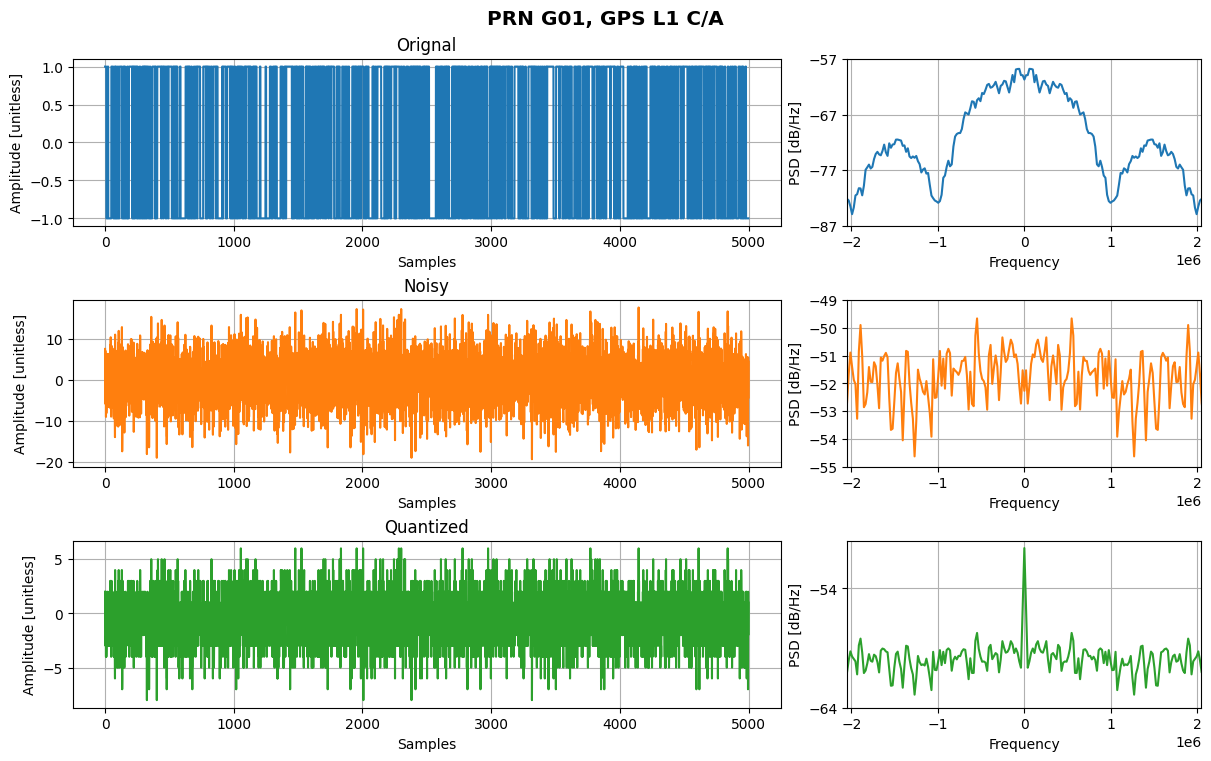

In [3]:
plotSignals({'Orignal' : signal, 'Noisy': signal_noisy, 'Quantized': signal_quantized}, 
            samplingFrequency, GPS_L1CA_CODE_FREQ, f"PRN G{prn:02d}, GPS L1 C/A")

### Perform correlation

In [4]:
# Correlate
signal_corr, signal_lags = correlate(signal, signal)
signal_noisy_corr, signal_noisy_lags = correlate(signal, signal_noisy)

In [5]:
signal_quantized_corr, signal_quantized_lags = correlate(signal, signal_quantized)

In [6]:
signal_axc_corr, signal_axc_lags = correlate(signal, signal_quantized, method='axc')

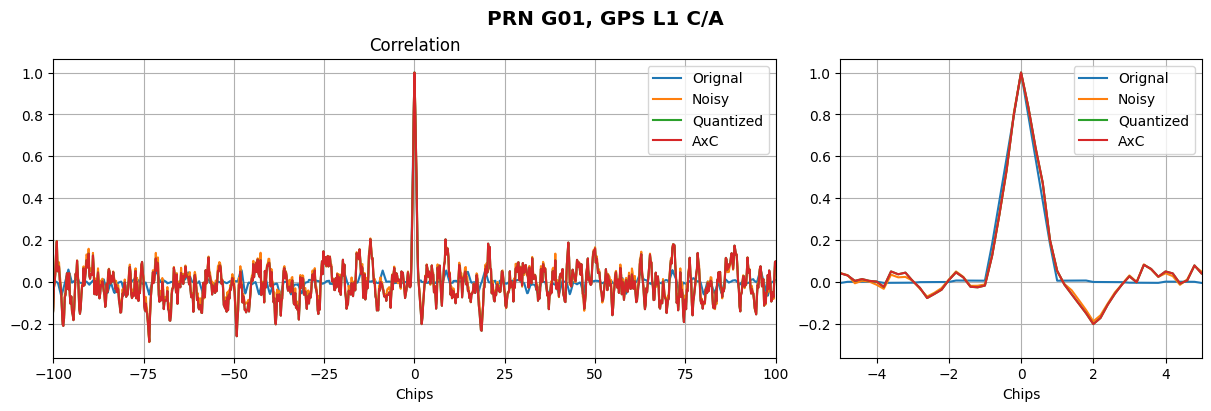

In [7]:
plotCorrelation({
'Orignal' : (signal_corr, signal_lags), 
'Noisy': (signal_noisy_corr, signal_noisy_lags), 
'Quantized': (signal_quantized_corr, signal_quantized_lags),
'AxC': (signal_axc_corr, signal_axc_lags)}, 
samplingFrequency, GPS_L1CA_CODE_FREQ, f"PRN G{prn:02d}, GPS L1 C/A")

In [8]:
len(np.unique(signal_quantized))

15

In [9]:
import numpy as np

class CustomTypeArray(np.ndarray):
    def __new__(cls, input_array):
        obj = np.asarray(input_array).view(cls)
        return obj

    # Define custom __add__ method with custom addition logic and printing
    def __add__(self, other):
        # Check data type compatibility (optional)
        if not isinstance(other, (CustomTypeArray, np.ndarray, np.number)):
            raise TypeError("Unsupported operand type(s) for +: 'CustomTypeArray' and '{}'".format(type(other)))

        # Custom addition logic and printing
        if isinstance(other, (CustomTypeArray, np.ndarray)):
            if self.shape != other.shape:
                raise ValueError("Shapes of operands must match")
            result = np.empty_like(self)  # Create empty array for result
            for i in range(len(self)):
                print(f"Adding elements at index {i}: {self[i]} + {other[i]}")
                result[i] = self[i] + other[i]  # Perform custom addition
            return CustomTypeArray(result)
        else:
            # Handle addition with a number (optional custom logic here)
            raise NotImplementedError("Addition with non-array operand not implemented")

# Example usage:
arr1 = CustomTypeArray([1, 2, 3])
arr2 = CustomTypeArray([4, 5, 6])

try:
  arr3 = arr1 + arr2  # Custom addition with printing
except NotImplementedError as e:
  print(e)

Adding elements at index 0: 1 + 4
Adding elements at index 1: 2 + 5
Adding elements at index 2: 3 + 6


In [60]:
import numpy as np
from matplotlib.ticker import MultipleLocator
from axcoperations import lcadd
import evoapproxlib as eal

axc_bits = 1 # Lower bits approximated
bits = 8
max_value = 2**bits // 2
i_range = np.arange(-max_value, max_value, dtype=np.int16)
j_range = np.arange(-max_value, max_value, dtype=np.int16)
exact_results = np.zeros((2**bits, 2**bits))
axc_results = np.zeros((2**bits, 2**bits))
for i in i_range:
    for j in j_range:
        #axc_results[i+max_value,j+max_value] = lcadd(i, j, axc_bits)
        axc_results[i+max_value,j+max_value] = eal.mul8s_1L1G.calc(i, j)
        exact_results[i+max_value,j+max_value] = i * j

error = exact_results - axc_results
minError = np.min(error)
maxError = np.max(error)

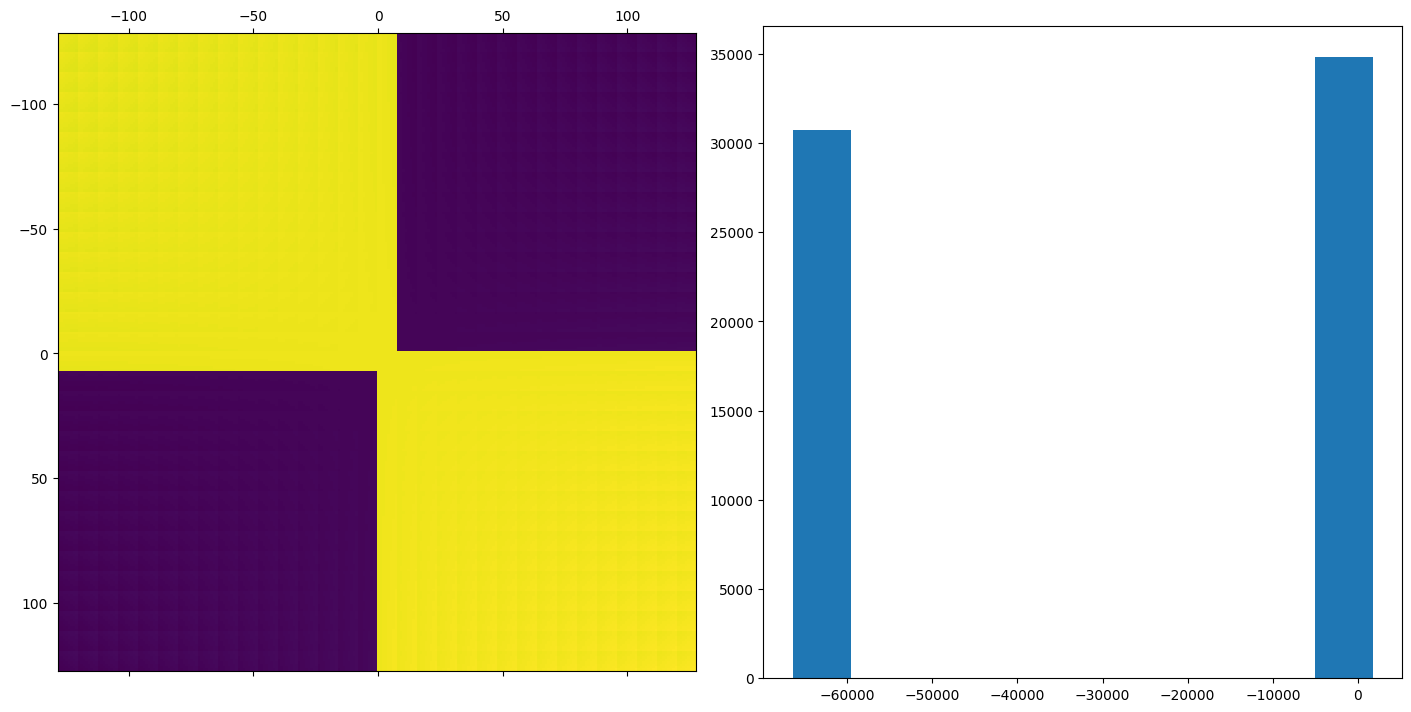

In [61]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 7), layout="constrained")
plot = axs[0].matshow(error, extent=(-max_value-0.5, max_value-0.5, max_value-0.5, -max_value-0.5))
ax.xaxis.set_major_locator(MultipleLocator(max_value/8))
ax.yaxis.set_major_locator(MultipleLocator(max_value/8))
cbar = fig.colorbar(plot, ax=axs[0])

axs[1] = plt.hist(error.flatten())

In [22]:
import evoapproxlib as eal
import pandas as pd 
import matplotlib.pyplot as plt

kpis = ["MAE_PERCENT", "MAE", "WCE_PERCENT", "WCE", "WCRE_PERCENT", "EP_PERCENT", 
        "MRE_PERCENT", "MSE", "PDK45_PWR", "PDK45_AREA", "PDK45_DELAY"]

module_list = []
for name, module in eal.multipliers['8x8_signed'].items():
    mdict = {"NAME": name}
    for k in kpis:
        mdict[k] = getattr(module, k)
    module_list.append(mdict)
    #print(f"{name} | {module.MAE:>6} | {module.WCE:>6} | {module.MSE:>9} | {module.PDK45_PWR:>9}")

df = pd.DataFrame(module_list) 


In [31]:
df = df.sort_values(by=['MAE'], ascending=False)
df

,NAME,MAE_PERCENT,MAE,WCE_PERCENT,WCE,WCRE_PERCENT,EP_PERCENT,MRE_PERCENT,MSE,PDK45_PWR,PDK45_AREA,PDK45_DELAY
0,mul8s_1KR3,3.0800,2016.0,12.3000,8064.0,6300.0,98.05,135.77,7282910.2,0.052,172.2,0.89
8,mul8s_1L1G,0.5200,340.0,2.6600,1743.0,6300.0,97.75,27.44,191238.0,0.126,284.9,0.94
2,mul8s_1KTY,0.3400,224.0,1.3700,896.0,700.0,87.16,15.72,95576.0,0.237,482.4,1.19
9,mul8s_1L2D,0.2300,150.0,1.1600,759.0,1500.0,93.16,12.26,38236.0,0.200,411.6,1.14
11,mul8s_1KVL,0.1500,101.0,0.6900,449.0,6500.0,91.89,8.93,19690.0,0.289,543.0,1.33
4,mul8s_1L2H,0.0810,53.0,0.3900,255.0,300.0,74.61,4.41,5462.0,0.301,558.9,1.36
10,mul8s_1KRC,0.0560,36.0,0.2500,161.0,3300.0,84.18,3.64,2872.0,0.351,599.8,1.36
5,mul8s_1KR6,0.0510,33.0,0.2100,137.0,900.0,74.80,2.73,2746.0,0.363,635.0,1.37
1,mul8s_1KR8,0.0490,32.0,0.2000,128.0,100.0,49.80,2.40,2731.0,0.369,652.8,1.37
12,mul8s_1KX2,0.0190,12.0,0.0750,49.0,4900.0,81.25,2.53,248.0,0.391,641.1,1.51


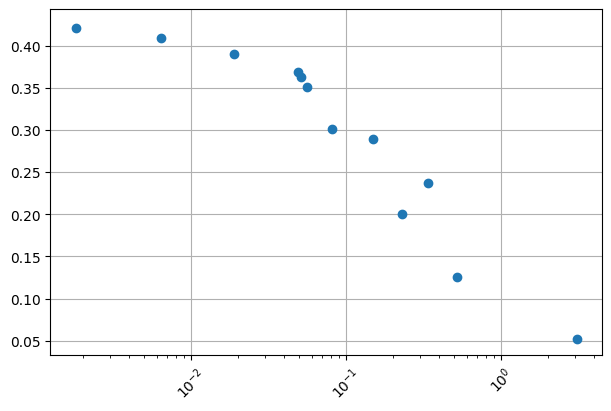

In [43]:
fig, ax = plt.subplots(figsize=(6, 4), layout="constrained")
plt.scatter(df['MAE_PERCENT'], df['PDK45_PWR'])
_ = plt.xticks(rotation=45)
plt.grid()
ax.set_axisbelow(True)
ax.set_xscale('log')